In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np

rgb = np.load(
    "/content/drive/MyDrive/rgb_dataloader/nyu_rgb_48x48.npy",
    mmap_mode="r"
)

depth = np.load(
    "/content/drive/MyDrive/rgb_dataloader/nyu_depth_48x48.npy",
    mmap_mode="r"
)

print(rgb.shape, depth.shape)


(1449, 48, 48, 3) (1449, 48, 48)


In [3]:
import numpy as np

BASE = "/content/drive/MyDrive/rgb_dataloader"

rgb   = np.load(f"{BASE}/nyu_rgb_48x48.npy", mmap_mode="r")
depth = np.load(f"{BASE}/nyu_depth_48x48.npy", mmap_mode="r")

N = len(rgb)
print("Total samples:", N)

# Split ratios
train_ratio = 0.8
val_ratio   = 0.1

indices = np.random.permutation(N)

train_end = int(train_ratio * N)
val_end   = int((train_ratio + val_ratio) * N)

train_idx = indices[:train_end]
val_idx   = indices[train_end:val_end]
test_idx  = indices[val_end:]


Total samples: 1449


In [4]:
np.save(f"{BASE}/rgb_train.npy",   rgb[train_idx])
np.save(f"{BASE}/depth_train.npy", depth[train_idx])

np.save(f"{BASE}/rgb_val.npy",     rgb[val_idx])
np.save(f"{BASE}/depth_val.npy",   depth[val_idx])

np.save(f"{BASE}/rgb_test.npy",    rgb[test_idx])
np.save(f"{BASE}/depth_test.npy",  depth[test_idx])

print("✅ Train / Val / Test saved successfully")


✅ Train / Val / Test saved successfully


In [5]:
rgb_train = np.load(f"{BASE}/rgb_train.npy", mmap_mode="r")
depth_train = np.load(f"{BASE}/depth_train.npy", mmap_mode="r")

print(rgb_train.shape)
print(depth_train.shape)


(1159, 48, 48, 3)
(1159, 48, 48)


In [6]:
import torch
from torch.utils.data import Dataset

class NYUDepth48(Dataset):
    def __init__(self, rgb_path, depth_path):
        self.rgb = np.load(rgb_path, mmap_mode="r")
        self.depth = np.load(depth_path, mmap_mode="r")

    def __len__(self):
        return len(self.rgb)

    def __getitem__(self, idx):
        rgb = torch.from_numpy(self.rgb[idx].copy()).permute(2,0,1).float()
        depth = torch.from_numpy(self.depth[idx].copy()).unsqueeze(0).float()
        return rgb, depth

In [7]:
from torch.utils.data import DataLoader

train_ds = NYUDepth48(
    f"{BASE}/rgb_train.npy",
    f"{BASE}/depth_train.npy"
)

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

rgb_batch, depth_batch = next(iter(train_loader))
print(rgb_batch.shape, depth_batch.shape)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([32, 3, 48, 48]) torch.Size([32, 1, 48, 48])


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PyDNet48(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)  # 24×24

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)  # 12×12

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )

        # Depth prediction at 12×12
        self.pred3 = nn.Conv2d(128, 1, 1)

        # Refinement to 24×24
        self.refine2 = nn.Sequential(
            nn.Conv2d(64 + 1, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.pred2 = nn.Conv2d(64, 1, 1)

        # Refinement to 48×48
        self.refine1 = nn.Sequential(
            nn.Conv2d(32 + 1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU()
        )
        self.pred1 = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        # Encoder
        f1 = self.conv1(x)            # 48×48
        f2 = self.conv2(self.pool1(f1))  # 24×24
        f3 = self.conv3(self.pool2(f2))  # 12×12

        # Coarse depth
        d3 = torch.sigmoid(self.pred3(f3))  # 12×12

        # Upsample + refine (24×24)
        d3_up = F.interpolate(d3, scale_factor=2, mode="bilinear", align_corners=False)
        r2 = self.refine2(torch.cat([f2, d3_up], dim=1))
        d2 = torch.sigmoid(self.pred2(r2))  # 24×24

        # Upsample + refine (48×48)
        d2_up = F.interpolate(d2, scale_factor=2, mode="bilinear", align_corners=False)
        r1 = self.refine1(torch.cat([f1, d2_up], dim=1))
        d1 = torch.sigmoid(self.pred1(r1))  # 48×48

        return d1, d2, d3


In [9]:
def multiscale_loss(preds, target):
    d1, d2, d3 = preds

    gt2 = F.interpolate(target, scale_factor=0.5, mode="bilinear", align_corners=False)
    gt3 = F.interpolate(target, scale_factor=0.25, mode="bilinear", align_corners=False)

    l1 = nn.L1Loss()(d1, target)
    l2 = nn.L1Loss()(d2, gt2)
    l3 = nn.L1Loss()(d3, gt3)

    return 0.6*l1 + 0.3*l2 + 0.1*l3


def rmse_loss(pred, target):
    return torch.sqrt(torch.mean((pred - target) ** 2))

def combined_loss(pred, target):
    return 0.7 * nn.L1Loss()(pred, target) + 0.3 * rmse_loss(pred, target)



In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

model = PyDNet48().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Using: cpu


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

model = PyDNet48().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Using: cpu


In [ ]:
num_epochs = 20
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for rgb, depth in train_loader:
        rgb = rgb.to(device)
        depth = depth.to(device)

        optimizer.zero_grad()
        preds = model(rgb)

        # Use the first (highest resolution) prediction for combined_loss
        loss = combined_loss(preds[0], depth)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {epoch_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/20]  Loss: 0.1467
Epoch [2/20]  Loss: 0.1142
Epoch [3/20]  Loss: 0.1117
Epoch [4/20]  Loss: 0.1106
Epoch [5/20]  Loss: 0.1100
Epoch [6/20]  Loss: 0.1104
Epoch [7/20]  Loss: 0.1092
Epoch [8/20]  Loss: 0.1080
Epoch [9/20]  Loss: 0.1072
Epoch [10/20]  Loss: 0.1078
Epoch [11/20]  Loss: 0.1075
Epoch [12/20]  Loss: 0.1067
Epoch [13/20]  Loss: 0.1074
Epoch [14/20]  Loss: 0.1082
Epoch [15/20]  Loss: 0.1073
Epoch [16/20]  Loss: 0.1079
Epoch [17/20]  Loss: 0.1064
Epoch [18/20]  Loss: 0.1070
Epoch [19/20]  Loss: 0.1073


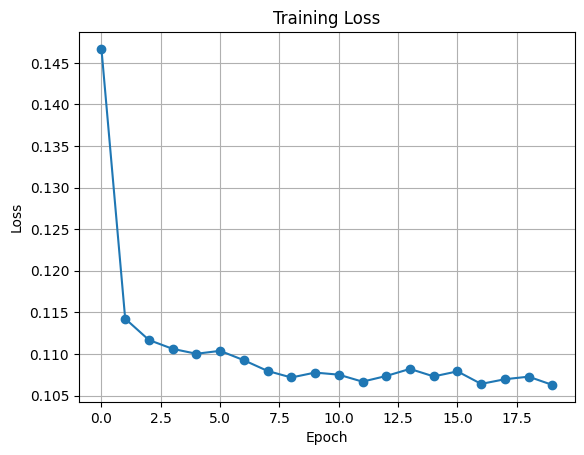

In [13]:
import matplotlib.pyplot as plt

plt.plot(train_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()


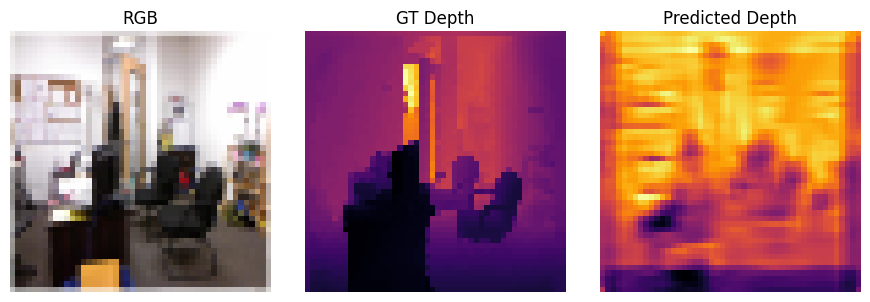

In [18]:


model.eval()

rgb, depth = next(iter(train_loader))
rgb = rgb.to(device)
depth = depth.to(device)

with torch.no_grad():
    pred = model(rgb)

rgb = rgb[0].permute(1,2,0).cpu().numpy()
gt  = depth[0,0].cpu().numpy()
pd  = pred[0][0,0].cpu().numpy()

plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.imshow((rgb*255).astype("uint8"))
plt.title("RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="inferno")
plt.title("GT Depth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pd, cmap="inferno")
plt.title("Predicted Depth")

plt.axis("off")

plt.tight_layout()
plt.show()

In [19]:
torch.save(model.state_dict(), "pydnet48.pth")
